# 1. 라이브러리 불러오기

In [17]:
import platform
import re

import pandas as pd
import numpy as np
pd.set_option('max.columns', 100)

import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import folium
plt.style.use('ggplot')
%matplotlib inline

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'AppleGothic'

# 2. 크롤링 데이터 불러오기

In [3]:
크롤링 = pd.read_csv('./data/장애인스포츠강좌이용권강좌_크롤링(좌표).csv', encoding = 'CP949')

# 'No', '상태' 변수는 삭제
크롤링.drop(['No', '상태'], axis = 1, inplace = True)

print('Shape of data :', 크롤링.shape, '\n')
print('-' * 50)
print(크롤링.info())

Shape of data : (1108, 18) 

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   시설명      1108 non-null   object 
 1   대표자      1102 non-null   object 
 2   연락처      1108 non-null   object 
 3   주소       1108 non-null   object 
 4   지도자      1108 non-null   object 
 5   시설면적     1108 non-null   object 
 6   운동종류     1108 non-null   object 
 7   장애종류     1108 non-null   object 
 8   강의명      1108 non-null   object 
 9   시간       1108 non-null   object 
 10  요일       1108 non-null   object 
 11  강사명      1098 non-null   object 
 12  기간       1108 non-null   object 
 13  차량지원     1108 non-null   object 
 14  장애 지원시설  666 non-null    object 
 15  수강료      1108 non-null   object 
 16  경도       1108 non-null   float64
 17  위도       1108 non-null   float64
dtypes: float64(2), object(16)
memory usage: 155.9+ K

In [4]:
# 데이터 일부 확인하기
display(크롤링.head())

,시설명,대표자,연락처,주소,지도자,시설면적,운동종류,장애종류,강의명,시간,요일,강사명,기간,차량지원,장애 지원시설,수강료,경도,위도
0,(사)신나는사상스포츠클럽,유재우,02-319-7330,부산광역시 사상구 가야대로 196번길 51 다누림센터,1명,1 ㎡,배드민턴,"지체, 시각, 청각/언어, 지적/자폐, 뇌병변, 기타",[12월] 생활체육,14:00 ~ 14:50,"화,목",소대승,2020.12.01 ~ 2020.12.10,미지원,"장애인 화장실,장애인용 엘리베이터,장애인전용 주차구역","80,000",128.994875,35.147446
1,(주)꿈자라다,김병식,031-719-1441,경기도 성남시 분당구 야탑로 32 삼부빌딜 4층(야탑동),11명,409 ㎡,기타종목,"지적/자폐, 기타",[12월] 특수체육,13:00 ~ 20:00,"월,화,수,목,금,토",류정국,2020.12.01 ~ 2020.12.10,미지원,"장애인 화장실,장애인용 엘리베이터,장애인전용 주차구역,주출입구 단차없음","80,000",127.122609,37.408783
2,(주)디에스그룹 달서복싱체육관 대곡점,정희준,02-244-7362,대구광역시 달성군 화원읍 비슬로 2707-1 4층 달서복싱,3명,3362 ㎡,복싱,"지체, 시각, 청각/언어, 지적/자폐, 기타",[12월] 신나는 운동 복싱교실 헬스,11:00 ~ 11:00,"월,화,수,목,금","정희준,,손예지",2020.12.01 ~ 2020.12.10,미지원,"장애인전용 주차구역,주출입구 단차없음,시각장애인 편의서비스,청각장애인 편의서비스","80,000",128.511287,35.809193
3,(주)스타칼리휘트니스,현보미,02-3141-4477,서울특별시 서대문구 연희로 82 브라운스톤 지하1층 스타칼리휘트니스(연희동),2명,1705 ㎡,헬스,기타,[12월] 헬스,06:00 ~ 23:55,"월,화,수,목,금,토,일",이원준,2020.12.01 ~ 2020.12.10,미지원,NaN,"80,000",126.930272,37.565213
4,(주)애플스포츠,최장용,043-854-1919,"충청북도 충주시 삼원로 75 1층,2층(봉방동)",2명,360 ㎡,롤러인라인,"청각/언어, 지적/자폐",[12월] 즐거운 인라인교실,10:00 ~ 19:00,"월,화,수,목,금,토",애플쌤,2020.12.01 ~ 2020.12.10,지원,NaN,"80,000",127.920623,36.973603


- 17 개의 **시/도**별로 보기 위해서는 **주소** 변수에서 **시/도** 부분을 추출해줘야 한다.

- 하지만 모든 관측치에 주소가 제대로 기입되어 있지 않음을 유의해야 한다.

In [5]:
def 주소_extract(value):

    # 우선 공백을 기준으로 값을 나눠준다.
    추출 = value.split(maxsplit = 2)
    
    # 중복되는 지명을 확인하기 위해서 분할한 값에서 두 개의 값을 list로 저장
    추출_list = [추출[0], 추출[1]]
    
    # 공백으로 문자열 함치기
    return " ".join(추출_list)

In [6]:
크롤링['시/도'] = [크롤링['주소'][index].split(maxsplit = 1)[0] for index in range(크롤링.shape[0])]

# 위에서 만들어준 함수 적용
크롤링['시군구'] = 크롤링['주소'].apply(주소_extract)
크롤링['시군구'] = 크롤링['시군구'].apply(lambda x: x.split()[1])

In [8]:
display(크롤링[['시/도', '시군구']].head())

,시/도,시군구
0,부산광역시,사상구
1,경기도,성남시
2,대구광역시,달성군
3,서울특별시,서대문구
4,충청북도,충주시


- 위 과정을 거쳐 시도와 시군구 정보를 추출하였다.

- 하지만 모든 관측치가 올바르게 추출된것이 아니기 때문에, 파일을 저장한 후 엑셀로 수정해주도록 한다.

```python
크롤링.to_csv('./data/장애인스포츠강좌이용권강좌_크롤링(좌표)_수정.csv', encoding = 'CP949')
```

# 3. '시군구' 변수 수정 데이터 불러오기

In [11]:
크롤링 = pd.read_csv('./data/장애인스포츠강좌이용권강좌_크롤링(좌표)_수정.csv', encoding = 'CP949')

# 사용하지 않는 변수 삭제
크롤링.drop(['Unnamed: 0', '대표자', '연락처', '지도자', '시설면적', '시/도명'], axis = 1, inplace = True)

# '시/도' 변수 확인
print('시/도의 개수 :', len(크롤링['시/도'].unique()), '\n')
print(크롤링['시/도'].unique())

시/도의 개수 : 47 

['부산광역시' '경기도' '대구광역시' '서울특별시' '충청북도' '울산광역시' '강원도' '경상남도' '전라남도' '전남'
 '광주' '서울시' '세종특별자치시' '경기' '북구' '경남' '경상북도' '의성군' '광주광역시' '대전광역시' '경북'
 '충남' '전라북도' '인천광역시' '충청남도' '수원시' '인천시' '충북' '대전시' '제주시' '부산시' '봉화군' '문경시'
 '제주특별자치도' '수성구' '순천시' '양주시' '서울' '영천시' '김천시' '전북' '의정부시' '대구' '경산시' '포항시'
 '강북구' '동래구']


- 각 관측치의 시/도 변수를 만들어 주려고 했지만 데이터에 기입된 주소가 일정하지 않음을 확인할 수 있다.

In [13]:
# '시군구' 변수를 사용하여 17개의 시/도 변수를 생성해주기 위해 리스트 객체 생성
부산 = ['부산광역시', '부산시', '동래구']

경기 = ['경기도', '경기', '수원시', '양주시', '의정부시']

대구 = ['대구광역시', '북구', '수성구', '대구']

서울 = ['서울특별시', '서울시', '서울', '강북구']

충북 = ['충청북도', '충북']
충남 = ['충남', '충청남도']

울산 = ['울산광역시']

강원 = ['강원도']

경남 = ['경상남도', '경남']
경북 = ['경상북도', '의성군', '경북', '봉화군', '문경시', '영천시', '김천시', '경산시', '포항시']

전남 = ['전라남도', '전남', '순천시']
전북 = ['전라북도', '전북']

광주 = ['광주', '광주광역시']

세종 = ['세종특별자치시']

대전 = ['대전광역시', '대전시']

인천 = ['인천광역시', '인천시']

제주 = ['제주시', '제주특별자치도']

In [14]:
시도_list = [부산, 경기, 대구, 서울, 충북, 충남, 울산, 강원, 경남, 경북, 전남, 전북, 광주, 세종, 대전, 인천, 제주]

시도_text_list = ['부산', '경기', '대구', '서울', '충북', '충남', '울산', '강원', '경남', '경북', '전남', '전북', '광주','세종', '대전', '인천', '제주']

# 반복문을 통해 '시/도' 변수 수정하기
for value, text in zip(시도_list, 시도_text_list):
    크롤링.loc[크롤링['시/도'].isin(value), '시/도'] = text

In [15]:
# 변환 후 '시/도'의 개수 확인하기
print('시/도의 개수 :', len(크롤링['시/도'].unique()), '\n')
print(크롤링['시/도'].unique())

시/도의 개수 : 17 

['부산' '경기' '대구' '서울' '충북' '울산' '강원' '경남' '전남' '광주' '세종' '경북' '대전' '충남'
 '전북' '인천' '제주']


- 17개의 시/도 변수가 정상적으로 생성되었음을 확인할 수 있다.

In [16]:
display(크롤링.head(3))

,시설명,주소,운동종류,장애종류,강의명,시간,요일,강사명,기간,차량지원,장애 지원시설,수강료,경도,위도,시/도,시군구
0,(사)신나는사상스포츠클럽,부산광역시 사상구 가야대로 196번길 51 다누림센터,배드민턴,"지체, 시각, 청각/언어, 지적/자폐, 뇌병변, 기타",[12월] 생활체육,14:00 ~ 14:50,"화,목",소대승,2020.12.01 ~ 2020.12.10,미지원,"장애인 화장실,장애인용 엘리베이터,장애인전용 주차구역","80,000",128.994875,35.147446,부산,사상구
1,(주)꿈자라다,경기도 성남시 분당구 야탑로 32 삼부빌딜 4층(야탑동),기타종목,"지적/자폐, 기타",[12월] 특수체육,13:00 ~ 20:00,"월,화,수,목,금,토",류정국,2020.12.01 ~ 2020.12.10,미지원,"장애인 화장실,장애인용 엘리베이터,장애인전용 주차구역,주출입구 단차없음","80,000",127.122609,37.408783,경기,성남시
2,(주)디에스그룹 달서복싱체육관 대곡점,대구광역시 달성군 화원읍 비슬로 2707-1 4층 달서복싱,복싱,"지체, 시각, 청각/언어, 지적/자폐, 기타",[12월] 신나는 운동 복싱교실 헬스,11:00 ~ 11:00,"월,화,수,목,금","정희준,,손예지",2020.12.01 ~ 2020.12.10,미지원,"장애인전용 주차구역,주출입구 단차없음,시각장애인 편의서비스,청각장애인 편의서비스","80,000",128.511288,35.809193,대구,달성군


- **장애종류** 변수에는 '지체', '시각', '청각', '언어', '지적', '자폐', '뇌병변', '기타' 총 8개의 유형이 있음을 볼 수 있다.


- 현재 위의 데이터에서 콤마(,)와 슬래시(/)로 저장되어 있으므로 각 장애유형을 하나의 변수로 만들어주자.

In [18]:
# 각 장애종류를 하나의 변수로 만들어주는 과정
크롤링['지체'] = 0
크롤링['시각'] = 0
크롤링['청각'] = 0
크롤링['언어'] = 0
크롤링['지적'] = 0
크롤링['자폐'] = 0
크롤링['뇌병변'] = 0
크롤링['기타'] = 0

for index in range(크롤링.shape[0]):
    
    # 're' 라이브러리의 split 함수를 사용해 나눠주기
    종류_list = re.split('[,/]', 크롤링['장애종류'][index])
    
    # 나눈 결과 양쪽 공백이 포함되는 경우도 있으므로 공백 제거
    종류_list = [value.strip() for value in 종류_list]
    
    if '지체' in 종류_list:
        크롤링.loc[index, '지체'] = 1
        
    if '시각' in 종류_list:
        크롤링.loc[index, '시각'] = 1
        
    if '청각' in 종류_list:
        크롤링.loc[index, '청각'] = 1
        
    if '언어' in 종류_list:
        크롤링.loc[index, '언어'] = 1
    
    if '지적' in 종류_list:
        크롤링.loc[index, '지적'] = 1
    
    if '자폐' in 종류_list:
        크롤링.loc[index, '자폐'] = 1
        
    if '뇌병변' in 종류_list:
        크롤링.loc[index, '뇌병변'] = 1
        
    if '기타' in 종류_list:
        크롤링.loc[index, '기타'] = 1
        
# 각 장애종류를 변수로 만든 후 장애종류 변수 삭제
크롤링.drop('장애종류', axis = 1, inplace = True)

In [19]:
# 변수 생성 후 데이터 확인
display(크롤링.head())

,시설명,주소,운동종류,강의명,시간,요일,강사명,기간,차량지원,장애 지원시설,수강료,경도,위도,시/도,시군구,지체,시각,청각,언어,지적,자폐,뇌병변,기타
0,(사)신나는사상스포츠클럽,부산광역시 사상구 가야대로 196번길 51 다누림센터,배드민턴,[12월] 생활체육,14:00 ~ 14:50,"화,목",소대승,2020.12.01 ~ 2020.12.10,미지원,"장애인 화장실,장애인용 엘리베이터,장애인전용 주차구역","80,000",128.994875,35.147446,부산,사상구,1,1,1,1,1,1,1,1
1,(주)꿈자라다,경기도 성남시 분당구 야탑로 32 삼부빌딜 4층(야탑동),기타종목,[12월] 특수체육,13:00 ~ 20:00,"월,화,수,목,금,토",류정국,2020.12.01 ~ 2020.12.10,미지원,"장애인 화장실,장애인용 엘리베이터,장애인전용 주차구역,주출입구 단차없음","80,000",127.122609,37.408783,경기,성남시,0,0,0,0,1,1,0,1
2,(주)디에스그룹 달서복싱체육관 대곡점,대구광역시 달성군 화원읍 비슬로 2707-1 4층 달서복싱,복싱,[12월] 신나는 운동 복싱교실 헬스,11:00 ~ 11:00,"월,화,수,목,금","정희준,,손예지",2020.12.01 ~ 2020.12.10,미지원,"장애인전용 주차구역,주출입구 단차없음,시각장애인 편의서비스,청각장애인 편의서비스","80,000",128.511288,35.809193,대구,달성군,1,1,1,1,1,1,0,1
3,(주)스타칼리휘트니스,서울특별시 서대문구 연희로 82 브라운스톤 지하1층 스타칼리휘트니스(연희동),헬스,[12월] 헬스,06:00 ~ 23:55,"월,화,수,목,금,토,일",이원준,2020.12.01 ~ 2020.12.10,미지원,NaN,"80,000",126.930272,37.565213,서울,서대문구,0,0,0,0,0,0,0,1
4,(주)애플스포츠,"충청북도 충주시 삼원로 75 1층,2층(봉방동)",롤러인라인,[12월] 즐거운 인라인교실,10:00 ~ 19:00,"월,화,수,목,금,토",애플쌤,2020.12.01 ~ 2020.12.10,지원,NaN,"80,000",127.920623,36.973603,충북,충주시,0,0,1,1,1,1,0,0


- **장애 지원시설** 변수에도 각 지원시설마다 콤마(,)로 저장되어 있으므로 위와 같은 작업을 수행해주도록 한다.

In [20]:
def 지원시설_extract(data):

    # 결측값을 가지지 않는 데이터를 추출하고 그 데이터의 index를 변수로 저장
    data1 = data[data['장애 지원시설'].isnull() == False]
    data1_list = data1.index
    
    # 장애 지원시설에 대한 변수 만들어주기
    data1['장애인 화장실'] = 0
    data1['장애인용 엘리베이터'] = 0
    data1['장애인전용 주차구역'] = 0
    data1['주출입구 단차없음'] = 0
    data1['휠체어 대여'] = 0
    data1['시각장애인 편의서비스'] = 0
    data1['청각장애인 편의서비스'] = 0
    
    for index in data1_list:
        지원시설_list = data1['장애 지원시설'][index].split(',')
        지원시설_list = [value.strip() for value in 지원시설_list]
        
        if '장애인 화장실' in 지원시설_list:
            data1.loc[index, '장애인 화장실'] = 1
            
        if '장애인용 엘리베이터' in 지원시설_list:
            data1.loc[index, '장애인용 엘리베이터'] = 1
            
        if '장애인전용 주차구역' in 지원시설_list:
            data1.loc[index, '장애인전용 주차구역'] = 1
            
        if '주출입구 단차없음' in 지원시설_list:
            data1.loc[index, '장애인전용 주차구역'] = 1
            
        if '휠체어 대여' in 지원시설_list:
            data1.loc[index, '휠체어 대여'] = 1
        
        if '시각장애인 편의서비스' in 지원시설_list:
            data1.loc[index, '시각장애인 편의서비스'] = 1
        
        if '청각장애인 편의서비스' in 지원시설_list:
            data1.loc[index, '청각장애인 편의서비스'] = 1
            
    data2 = data[data['장애 지원시설'].isnull() == True]
    data2_list = data2.index
    
    # 장애 지원시설에 대한 변수 만들어주기
    data2['장애인 화장실'] = 0
    data2['장애인용 엘리베이터'] = 0
    data2['장애인전용 주차구역'] = 0
    data2['주출입구 단차없음'] = 0
    data2['휠체어 대여'] = 0
    data2['시각장애인 편의서비스'] = 0
    data2['청각장애인 편의서비스'] = 0
    
    for index in data2_list:
        data2.loc[index, '장애인 화장실'] = 0
        data2.loc[index, '장애인용 엘리베이터'] = 0
        data2.loc[index, '장애인전용 주차구역'] = 0
        data2.loc[index, '주출입구 단차없음'] = 0
        data2.loc[index, '휠체어 대여'] = 0
        data2.loc[index, '시각장애인 편의서비스'] = 0
        data2.loc[index, '청각장애인 편의서비스'] = 0
        
    크롤링_변환 = pd.concat([data1, data2], ignore_index = True)
    
    return 크롤링_변환

In [21]:
크롤링_변환 = 지원시설_extract(크롤링)

# 장애 지원시설 변수 삭제하기
크롤링_변환.drop('장애 지원시설', axis = 1, inplace = True)

# '수강료' 변수가 object 타입이므로 ','를 제거하고 실수형으로 변환
크롤링_변환['수강료'] = pd.to_numeric([re.sub(",", "", value) for value in 크롤링_변환['수강료']])

print('Shape Of 변경 데이터 :', 크롤링_변환.shape, '\n')
print('-' * 40)
print(크롤링_변환.info())

Shape Of 변경 데이터 : (1108, 29) 

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시설명          1108 non-null   object 
 1   주소           1108 non-null   object 
 2   운동종류         1108 non-null   object 
 3   강의명          1108 non-null   object 
 4   시간           1108 non-null   object 
 5   요일           1108 non-null   object 
 6   강사명          1098 non-null   object 
 7   기간           1108 non-null   object 
 8   차량지원         1108 non-null   object 
 9   수강료          1108 non-null   int64  
 10  경도           1108 non-null   float64
 11  위도           1108 non-null   float64
 12  시/도          1108 non-null   object 
 13  시군구          1108 non-null   object 
 14  지체           1108 non-null   int64  
 15  시각           1108 non-null   int64  
 16  청각           1108 non-null   int64  
 17  언어           1108 

- 모든 수정 작업을 마친 데이터를 가지고 지도시각화를 수행해보도록 하자.

# 4. 지도시각화

In [22]:
def 지도시각화(raw_data):
    지도 = folium.Map(location = [36.40886055894505, 127.63462243700751], zoom_start = 8)
    
    # 시/도명 입력 받기
    시도명 = input('1. 거주하고 계신 시/도명을 입력해주세요 : ')
    print()
    
    # 시군구 입력 받기
    시군구_list = raw_data[raw_data['시/도'] == 시도명]['시군구'].unique()
    print(시군구_list, '\n')
    시군구 = input('2. 위에서 행정구역을 선택해 주세요 : ')
    print()
    
    # 장애종류를 보여주기 위해 장애_list 변수 지정
    장애_list = ['지체', '시각', '청각', '언어', '지적', '자폐', '뇌병변', '기타']
    print('')
    print(장애_list, '\n')
    
    # 장애명 입력 받기
    장애명 = input('3. 위에서 장애명을 선택해주세요 : ')
    print('\n')
    
    # 입력한 데이터에서 사용자가 위치해 있는 '시/도'와 사용자의 장애명에 일치하는 데이터를 추출
    data = raw_data[(raw_data['시/도'] == 시도명) & (raw_data[장애명] == 1) & (raw_data['시군구'] == 시군구)]
    
    # 추출된 데이터에서 가능한 운동종류를 출력
    운동_list = data['운동종류'].unique()
    print('위에서 선택한 조건으로 수강가능한 운동은 다음과 같습니다', '\n')
    print(운동_list, '\n')
    
    # 운동명 입력 받기
    운동명 = input('4. 수강 운동을 선택해주세요 : ')
    
    # 사용자가 선택한 운동 종목을 추출
    data = data[data['운동종류'] == 운동명]
    
    for index in data.index:
        # 추출한 데이터에서 '위도'와 '경도'를 변수로 지정
        위도 = data.loc[index, '위도']
        경도 = data.loc[index, '경도']
        
        # 지도시각화를 했을 때 '시설명'과 '수강료'를 볼 수 있도록 변수로 지정
        시설명 = data.loc[index, '시설명']
        수강료 = data.loc[index, '수강료']
        
        # [시작] 지도시각화를 했을 때 지원가능한 장애시설이 무엇이 있는지 확인할 수 있도록 해주는 과정
        장애지원_list = []
        
        if data.loc[index, '장애인 화장실'] == 1:
            장애지원_list.append('장애인 화장실')
            
        if data.loc[index, '장애인용 엘리베이터'] == 1:
            장애지원_list.append('장애인용 엘리베이터')
            
        if data.loc[index, '장애인전용 주차구역'] == 1:
            장애지원_list.append('장애인전용 주차구역')
            
        if data.loc[index, '주출입구 단차없음'] == 1:
            장애지원_list.append('주출입구 단차없음')
            
        if data.loc[index, '휠체어 대여'] == 1:
            장애지원_list.append('휠체어 대여')
            
        if data.loc[index, '시각장애인 편의서비스'] == 1:
            장애지원_list.append('시각장애인 편의서비스')
            
        if data.loc[index, '청각장애인 편의서비스'] == 1:
            장애지원_list.append('청각장애인 편의서비스')
        # [끝] 지도시각화를 했을 때 지원가능한 장애시설이 무엇이 있는지 확인할 수 있도록 해주는 과정
        
        # tooltip 설정해주는 과정
        text_1 = '''시설명 : {} 수강료 : {} 원'''.format(시설명, 수강료)
        tooltip = folium.Tooltip(text_1)
        
        # 차량 지원에 따라 색상 지정
        color = 'blue'
        
        if data.loc[index, '차량지원'] == '미지원':
            color = 'red'
        
        # poput 설정해주는 과정
        text_2 = ", ".join(장애지원_list)
        
        # 지원시설이 없는 경우 오류가 날 수 있기 때문에 따로 지정
        if len(장애지원_list) >= 1:
            popup = folium.Popup(text_2, max_width = 150)
            folium.CircleMarker([위도, 경도], popup = popup, color = color, tooltip = tooltip, radius = 8).add_to(지도)
            
        else:
            folium.CircleMarker([위도, 경도], popup = '지원시설 없습니다.', color = color, tooltip = tooltip, radius = 8).add_to(지도)
        
    return 지도

In [23]:
경기도_의정부시 = 지도시각화(크롤링_변환)

1. 거주하고 계신 시/도명을 입력해주세요 :  경기



['성남시' '광주시' '평택시' '의정부시' '고양시' '구리시' '수원시' '팔달구' '화성시' '남양주시' '시흥시' '안산시'
 '부천시' '의왕시' '안양시' '김포시' '광명시' '용인시' '안성시' '양주시' '과천시' '하남시' '권선구' '연천군'
 '파주시' '군포시' '가평군' '포천시'] 



2. 위에서 행정구역을 선택해 주세요 :  의정부시




['지체', '시각', '청각', '언어', '지적', '자폐', '뇌병변', '기타'] 



3. 위에서 장애명을 선택해주세요 :  지적




위에서 선택한 조건으로 수강가능한 운동은 다음과 같습니다 

['태권도' '기타종목' '볼링' '수영' '탁구' '요가'] 



4. 수강 운동을 선택해주세요 :  태권도


In [24]:
경기도_의정부시

# 5. 장애유형별 대표강좌 살펴보기

- 강좌 수가 많은 '경기', '부산', '서울', '대구' 4개의 지역을 살펴보도록 하자.

In [26]:
# 하나의 시설에서 요일을 다르게 같은 운동을 진행하는 경우도 있으니 중복값 제거
경기_data = 크롤링_변환[크롤링_변환['시/도'] == '경기']
경기_data = 경기_data.drop_duplicates(subset = ['시설명', '운동종류'])
print('경기도 데이터의 개수 :', 경기_data.shape, '\n')

부산_data = 크롤링_변환[크롤링_변환['시/도'] == '부산']
부산_data = 부산_data.drop_duplicates(subset = ['시설명', '운동종류'])
print('부산광역시 데이터의 개수 :', 부산_data.shape, '\n')

서울_data = 크롤링_변환[크롤링_변환['시/도'] == '서울']
서울_data = 서울_data.drop_duplicates(subset = ['시설명', '운동종류'])
print('서울시 데이터의 개수 :', 서울_data.shape, '\n')

대구_data = 크롤링_변환[크롤링_변환['시/도'] == '대구']
대구_data = 대구_data.drop_duplicates(subset = ['시설명', '운동종류'])
print('대구광역시 데이터의 개수 :', 대구_data.shape)

경기도 데이터의 개수 : (143, 29) 

부산광역시 데이터의 개수 : (86, 29) 

서울시 데이터의 개수 : (101, 29) 

대구광역시 데이터의 개수 : (78, 29)


In [31]:
대표지역_list = [경기_data, 부산_data, 서울_data, 대구_data]

def 장애유형별_시각화(장애명 = '지체', 지역_list = ['경기', '부산', '서울', '대구']):

    # 시각화를 그릴 틀 만들기
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
    
    for num, (data, reg) in enumerate(zip(대표지역_list, 지역_list)):
        
        # 시각화를 그릴 데이터 지정
        plot_data = pd.DataFrame(data[data[장애명] == 1]['운동종류'].value_counts())
        
        # 현재 Subplot의 행/열 번호를 갱신한다.
        r = int(num / 2)
        c = num % 2
        
        # 그래프 그리기
        sns.barplot(x = plot_data.index, y = '운동종류', data = plot_data, ax = axes[r][c])
        axes[r][c].set_title('{} 지역 *{}*유형 강좌 수'.format(reg, 장애명), fontsize = 13)
        axes[r][c].set_xticklabels(axes[r][c].get_xticklabels(), rotation = 45, ha = 'right')
        axes[r][c].get_yaxis().set_visible(False)
        axes[r][c].set_xlabel('')
        axes[r][c].set_ylabel('')
    
    return fig.tight_layout()

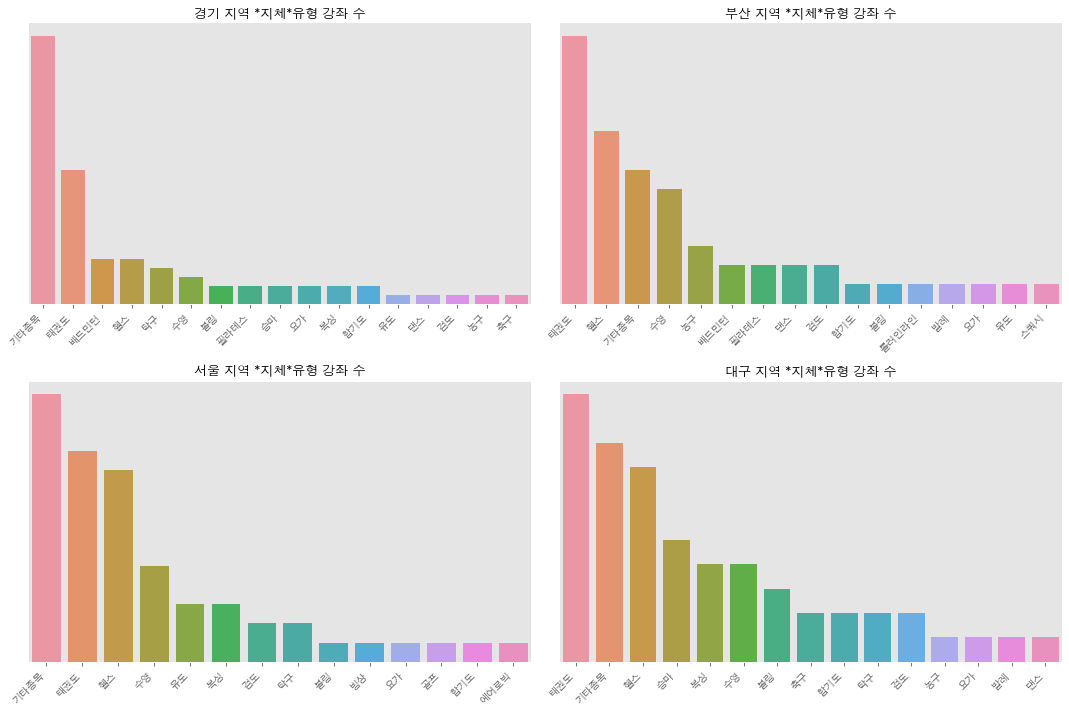

In [32]:
장애유형별_시각화()

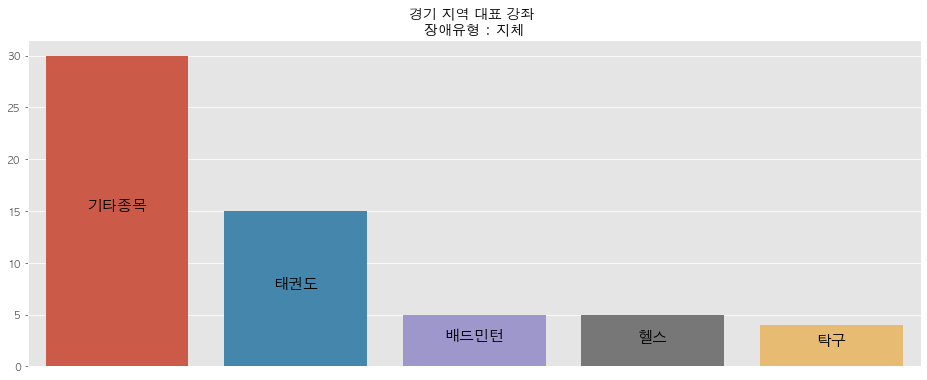

In [33]:
plt.figure(figsize = (16, 6))

plot_data = pd.DataFrame(경기_data[경기_data['지체'] == 1]['운동종류'].value_counts()).head(5)

ax = sns.barplot(x = plot_data.index, y = '운동종류', data = plot_data)
ax.set_title("경기 지역 대표 강좌 \n장애유형 : 지체", fontsize = 14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_xaxis().set_visible(False)

for index, value in enumerate(plot_data.index):
    ax.text(index, plot_data.iloc[index]['운동종류'] / 2, value, fontsize = 15, ha = 'center')

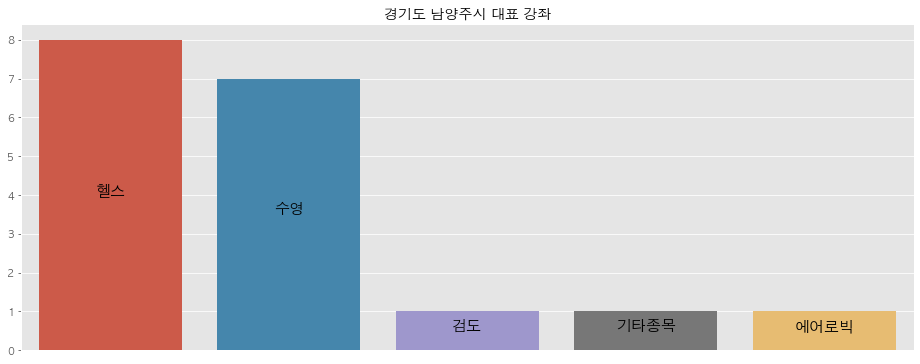

In [34]:
plt.figure(figsize = (16, 6))

plot_data = pd.DataFrame(경기_data[경기_data['시군구'] == '남양주시']['운동종류'].value_counts()).head(5)

ax = sns.barplot(x = plot_data.index, y = '운동종류', data = plot_data)
ax.set_title("경기도 남양주시 대표 강좌", fontsize = 14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_xaxis().set_visible(False)

for index, value in enumerate(plot_data.index):
    ax.text(index, plot_data.iloc[index]['운동종류'] / 2, value, fontsize = 15, ha = 'center')